In [1]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

c:\Programming\anaconda3\envs\chem2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [ ]:
df_freesolv= 'scgas'
df_esol = 'solubility'
save_dir = r'..\results_figure\pca'

In [5]:
path = f'../datasets/{df_freesolv}.csv'
df = pd.read_csv(path)
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['COC(F)(F)C(F)(F)C(F)(F)F', 'COC(F)(F)C(F)(F)F', 'Brc1cc(Br)c(cc1)Oc1ccc(Br)c(Br)c1Br', 'Clc1c(Oc2ccccc2)c(Cl)ccc1Cl', 'Clc1cc(Oc2ccccc2)c(Cl)c(Cl)c1']
0    2.75
1    3.21
2   -8.14
3   -3.55
4   -3.66
Name: logvp, dtype: float64


In [6]:
from descriptor_selection.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 12 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 9 

0       False
1       False
2       False
3       False
4       False
        ...  
3127    False
3128    False
3129    False
3130    False
3131    False
Length: 3132, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4    

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.734375,-6.326875,11.734375,0.055208,0.621657,200.053,197.029,200.007212,74,0.462384,...,0,0,0,0,0,0,0,0,0,2.750000
1,11.312500,-5.609375,11.312500,0.285208,0.517465,150.046,147.022,150.010406,56,0.482450,...,0,0,0,0,0,0,0,0,0,3.210000
2,5.865324,0.743609,5.865324,0.743609,0.348269,564.691,559.651,559.625725,94,0.142392,...,0,0,0,0,0,0,0,0,0,-8.140000
3,6.007009,0.317611,6.007009,0.317611,0.662096,273.546,266.490,271.956248,82,0.165603,...,0,0,0,0,0,0,0,0,0,-3.550000
4,5.999509,0.356407,5.999509,0.356407,0.662096,273.546,266.490,271.956248,82,0.148525,...,0,0,0,0,0,0,0,0,0,-3.660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,2.448171,0.882574,2.448171,0.882574,0.354496,268.529,228.209,268.313001,116,-0.044280,...,0,0,0,0,0,0,0,0,0,-2.356547
3119,12.494448,0.134167,12.494448,0.134167,0.445095,230.266,220.186,230.073165,84,0.193794,...,0,0,0,0,0,0,0,0,0,-6.657577
3120,11.425278,-1.121250,11.425278,0.872593,0.706401,260.336,244.208,260.120115,98,0.140063,...,0,0,0,0,0,0,0,0,0,-7.522879
3121,2.274907,1.278241,2.274907,1.278241,0.384372,254.332,240.220,254.109550,94,-0.002682,...,0,0,0,0,0,0,0,0,0,-7.045757


# PCA

In [7]:
# target split
target_freesolv = df_removed_features.iloc[:,-1]

# 1/3
med1_freesolv = np.percentile(target_freesolv, 33)
med2_freesolv = np.percentile(target_freesolv, 66)

low_freesolv = np.where(target_freesolv < med1_freesolv)[0]
mid_freesolv = np.where((target_freesolv >= med1_freesolv) & (target_freesolv < med2_freesolv))[0]
high_freesolv = np.where(target_freesolv >= med2_freesolv)[0]

X_freesolv = np.array(df_removed_features.drop(columns = ['target']))
X_freesolv.shape

(3123, 190)

In [8]:
PCA_model2D_freesolv = PCA(n_components = 2)
PCA_model3D_freesolv = PCA(n_components = 3)

scaler_freesolv = StandardScaler()

X_scaling_freesolv = scaler_freesolv.fit_transform(X_freesolv)

X_pca2D_freesolv = PCA_model2D_freesolv.fit_transform(X_scaling_freesolv)
X_pca3D_freesolv = PCA_model3D_freesolv.fit_transform(X_scaling_freesolv)

In [9]:
path = f'../datasets/{df_esol}.csv'
df = pd.read_csv(path)
smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCCCCCCCCCCCC', 'C/C(=C\\CC/C=C(/CC/C=C(/CCC=C(C)C)\\C)\\C)/CC/C=C(/CCC=C(C)C)\\C', 'ClCCN(c1ccc(cc1)CC(=O)O[C@H]1CC[C@]2(C(=CC[C@@H]3[C@@H]2CC[C@]2([C@H]3CC[C@@H]2[C@@H](CCCC(C)C)C)C)C1)C)CCCl', 'C[C@@H](CCC[C@]1(C)CCc2c(O1)c(C)c(c(c2C)OC(=O)c1cccnc1)C)CCC[C@@H](CCCC(C)C)C', 'CCCCCCCOc1ccc(c2c1cccc2)C(=N)[NH+](CCCCCCCC)CCCCCCCC.[Cl-]']
0   -17.468457
1   -14.592367
2   -14.523872
3   -13.798574
4   -13.619359
Name: solubility, dtype: float64


In [10]:
from descriptor_selection.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 8 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 239 

0       False
1       False
2       False
3       False
4       False
        ...  
8784    False
8785    False
8786    False
8787    False
8788    False
Length: 8789, dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 0 

0       False
1       False
2       False
3       False
4   

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,12.348360,0.083005,12.348360,0.083005,0.073635,641.082,564.474,640.590680,266,0.223869,...,0,0,0,0,0,0,0,26,0,-17.468457
1,2.433950,1.170647,2.433950,1.170647,0.185870,410.730,360.330,410.391252,170,-0.028825,...,0,0,0,0,0,0,0,1,0,-14.592367
2,13.030324,-0.104670,13.030324,0.011100,0.121593,644.812,585.340,643.392285,246,0.310040,...,0,0,0,0,0,0,0,0,0,-14.523872
3,12.743711,-0.370444,12.743711,0.143661,0.178364,535.813,482.389,535.402545,216,0.344621,...,0,0,0,0,0,0,0,0,0,-13.798574
4,9.286665,0.000000,9.286665,0.000000,0.104454,545.296,487.840,544.415942,216,0.225987,...,0,0,0,0,0,0,0,12,0,-13.619359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,3.222222,1.250000,3.222222,1.250000,0.434794,71.123,62.051,71.073499,30,-0.004845,...,0,0,0,0,0,0,0,0,0,1.150000
8546,9.000000,-0.833333,9.000000,0.833333,0.429883,60.052,56.020,60.021129,24,0.299685,...,0,0,0,0,0,0,0,0,0,1.220000
8547,4.597222,1.652778,4.597222,1.652778,0.273315,46.073,40.025,46.053098,20,-0.001725,...,0,0,0,0,0,0,0,0,0,1.340000
8548,7.000000,1.000000,7.000000,1.000000,0.385284,32.042,28.010,32.026215,14,0.031941,...,0,0,0,0,0,0,0,0,0,1.570000


In [11]:
# target split
target_esol = df_removed_features.iloc[:,-1]

# 1/3
med1_esol = np.percentile(target_esol, 33)
med2_esol = np.percentile(target_esol, 66)

low_esol = np.where(target_esol < med1_esol)[0]
mid_esol = np.where((target_esol >= med1_esol) & (target_esol < med2_esol))[0]
high_esol = np.where(target_esol >= med2_esol)[0]

X_esol = np.array(df_removed_features.drop(columns = ['target']))
X_esol.shape

(8550, 200)

In [12]:
PCA_model2D_esol = PCA(n_components = 2)
PCA_model3D_esol = PCA(n_components = 3)

scaler_esol = StandardScaler()

X_scaling_esol = scaler_esol.fit_transform(X_esol)

X_pca2D_esol = PCA_model2D_esol.fit_transform(X_scaling_esol)
X_pca3D_esol = PCA_model3D_esol.fit_transform(X_scaling_esol)

..\results_figure\pca\32.pdf


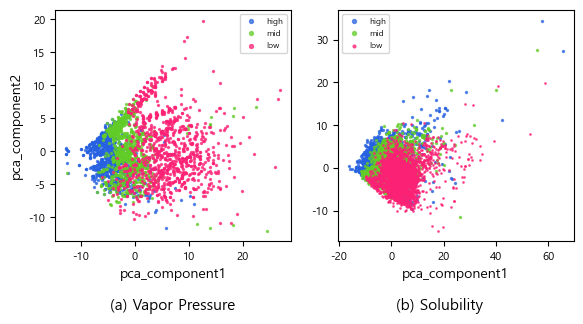

In [ ]:
# 3등분 2D
# pca
fig = plt.figure(figsize=(6.69, 3.0))
ax1 = fig.add_subplot(121)

ax1.scatter(X_pca2D_freesolv[high_freesolv, 0], X_pca2D_freesolv[high_freesolv, 1], label='high', c='#2661e1', alpha=0.7, s=2)
ax1.scatter(X_pca2D_freesolv[mid_freesolv, 0], X_pca2D_freesolv[mid_freesolv, 1], label='mid', c='#62CC28', alpha=0.7, s=2)
ax1.scatter(X_pca2D_freesolv[low_freesolv, 0], X_pca2D_freesolv[low_freesolv, 1], label='low', c='#FC2175', alpha=0.7, s=2)

ax1.set_xlabel('pca_component1')
ax1.set_ylabel('pca_component2')
ax1.legend(markerscale=2, fontsize=6)
ax1.tick_params(axis='both', labelsize=8)

ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D_esol[high_esol, 0], X_pca2D_esol[high_esol, 1], label='high', c='#2661e1', alpha=0.7, s=2)
ax2.scatter(X_pca2D_esol[mid_esol, 0], X_pca2D_esol[mid_esol, 1], label='mid', c='#62CC28', alpha=0.7, s=2)
ax2.scatter(X_pca2D_esol[low_esol, 0], X_pca2D_esol[low_esol, 1], label='low', c='#FC2175', alpha=0.7, s=1)

ax2.set_xlabel('pca_component1')
# ax2.set_ylabel('pca_component2')
ax2.legend(markerscale=2, fontsize=6)
ax2.tick_params(axis='both', labelsize=8)

fig.text(0.30, -0.12, "(a) Vapor Pressure", ha="center", fontsize=11)
fig.text(0.70, -0.12, "(b) Solubility", ha="center", fontsize=11)

# # 저장
# file_name = '10.pdf'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi=300, bbox_inches = "tight")

plt.show()